In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from nltk.corpus import stopwords
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline
%config InlineBackend.figure_format ='retina'

### Setting Parameters for Reddit WebScraping through Pushshift API

In [2]:
base_url = 'https://api.pushshift.io/reddit/submission/search'

first_params = {
    "subreddit" : 'nfl', 
    "size" : 1_000,
}

In [3]:
res = requests.get(base_url,first_params)

can only scrape 1,000 reddit posts at a time. saving the UTC time of last post from first iteration of web scrape as variable to continue collecting after that post.

In [4]:
last_post_utc = res.json()['data'][999]['created_utc']

In [5]:
subsequent_params = {
    "subreddit" : 'nfl', 
    "size" : 1_000,
    'before': last_post_utc
}

for loop to scrape remainder of posts from NFL subreddit. also, combining all posts in one dataframe

In [6]:
nfl = []
for i in range(10):
    res2 = requests.get(base_url,subsequent_params)
    last_post_utc = res2.json()['data'][999]['created_utc']
    reddit_df = pd.DataFrame(res2.json()['data'])[['title', 'selftext', 'subreddit']]
    nfl.append(reddit_df)
    subsequent_params = {
    "subreddit" : 'nfl', 
    "size" : 1_000,
    'before': last_post_utc
}
nfl_df = pd.concat(nfl)

In [7]:
base_url = 'https://api.pushshift.io/reddit/submission/search'

first_params = {
    "subreddit" : 'cfb', 
    "size" : 1_000,
}

In [8]:
res = requests.get(base_url,first_params)

In [9]:
last_post_utc = res.json()['data'][999]['created_utc']

In [10]:
subsequent_params = {
    "subreddit" : 'cfb', 
    "size" : 1_000,
    'before': last_post_utc
}

for loop to scrape cfb subreddit posts. combining all those posts into one dataframe

In [11]:
cfb = []
for i in range(10):
    res2 = requests.get(base_url,subsequent_params)
    last_post_utc = res2.json()['data'][999]['created_utc']
    reddit_df = pd.DataFrame(res2.json()['data'])[['title', 'selftext', 'subreddit']]
    cfb.append(reddit_df)
    subsequent_params = {
    "subreddit" : 'cfb', 
    "size" : 1_000,
    'before': last_post_utc
}
cfb_df = pd.concat(cfb)

combining nfl and cfb posts

In [12]:
combined_df = pd.concat([nfl_df, cfb_df])

adding character and word count features to combined dataframe

In [13]:
combined_df['char_count'] = combined_df.title.map(len)

In [14]:
combined_df['word_count'] = combined_df.title.map(lambda x: len(x.split()))

dummying subreddit column to make categorical data numeric

In [15]:
combined_df['subreddit'] = combined_df['subreddit'].map({'nfl':1, 'CFB':0})

assigning dummied subreddit column as target

In [16]:
target = combined_df['subreddit']

plotting bar chart that compares cfb's and nfl's subreddits character counts

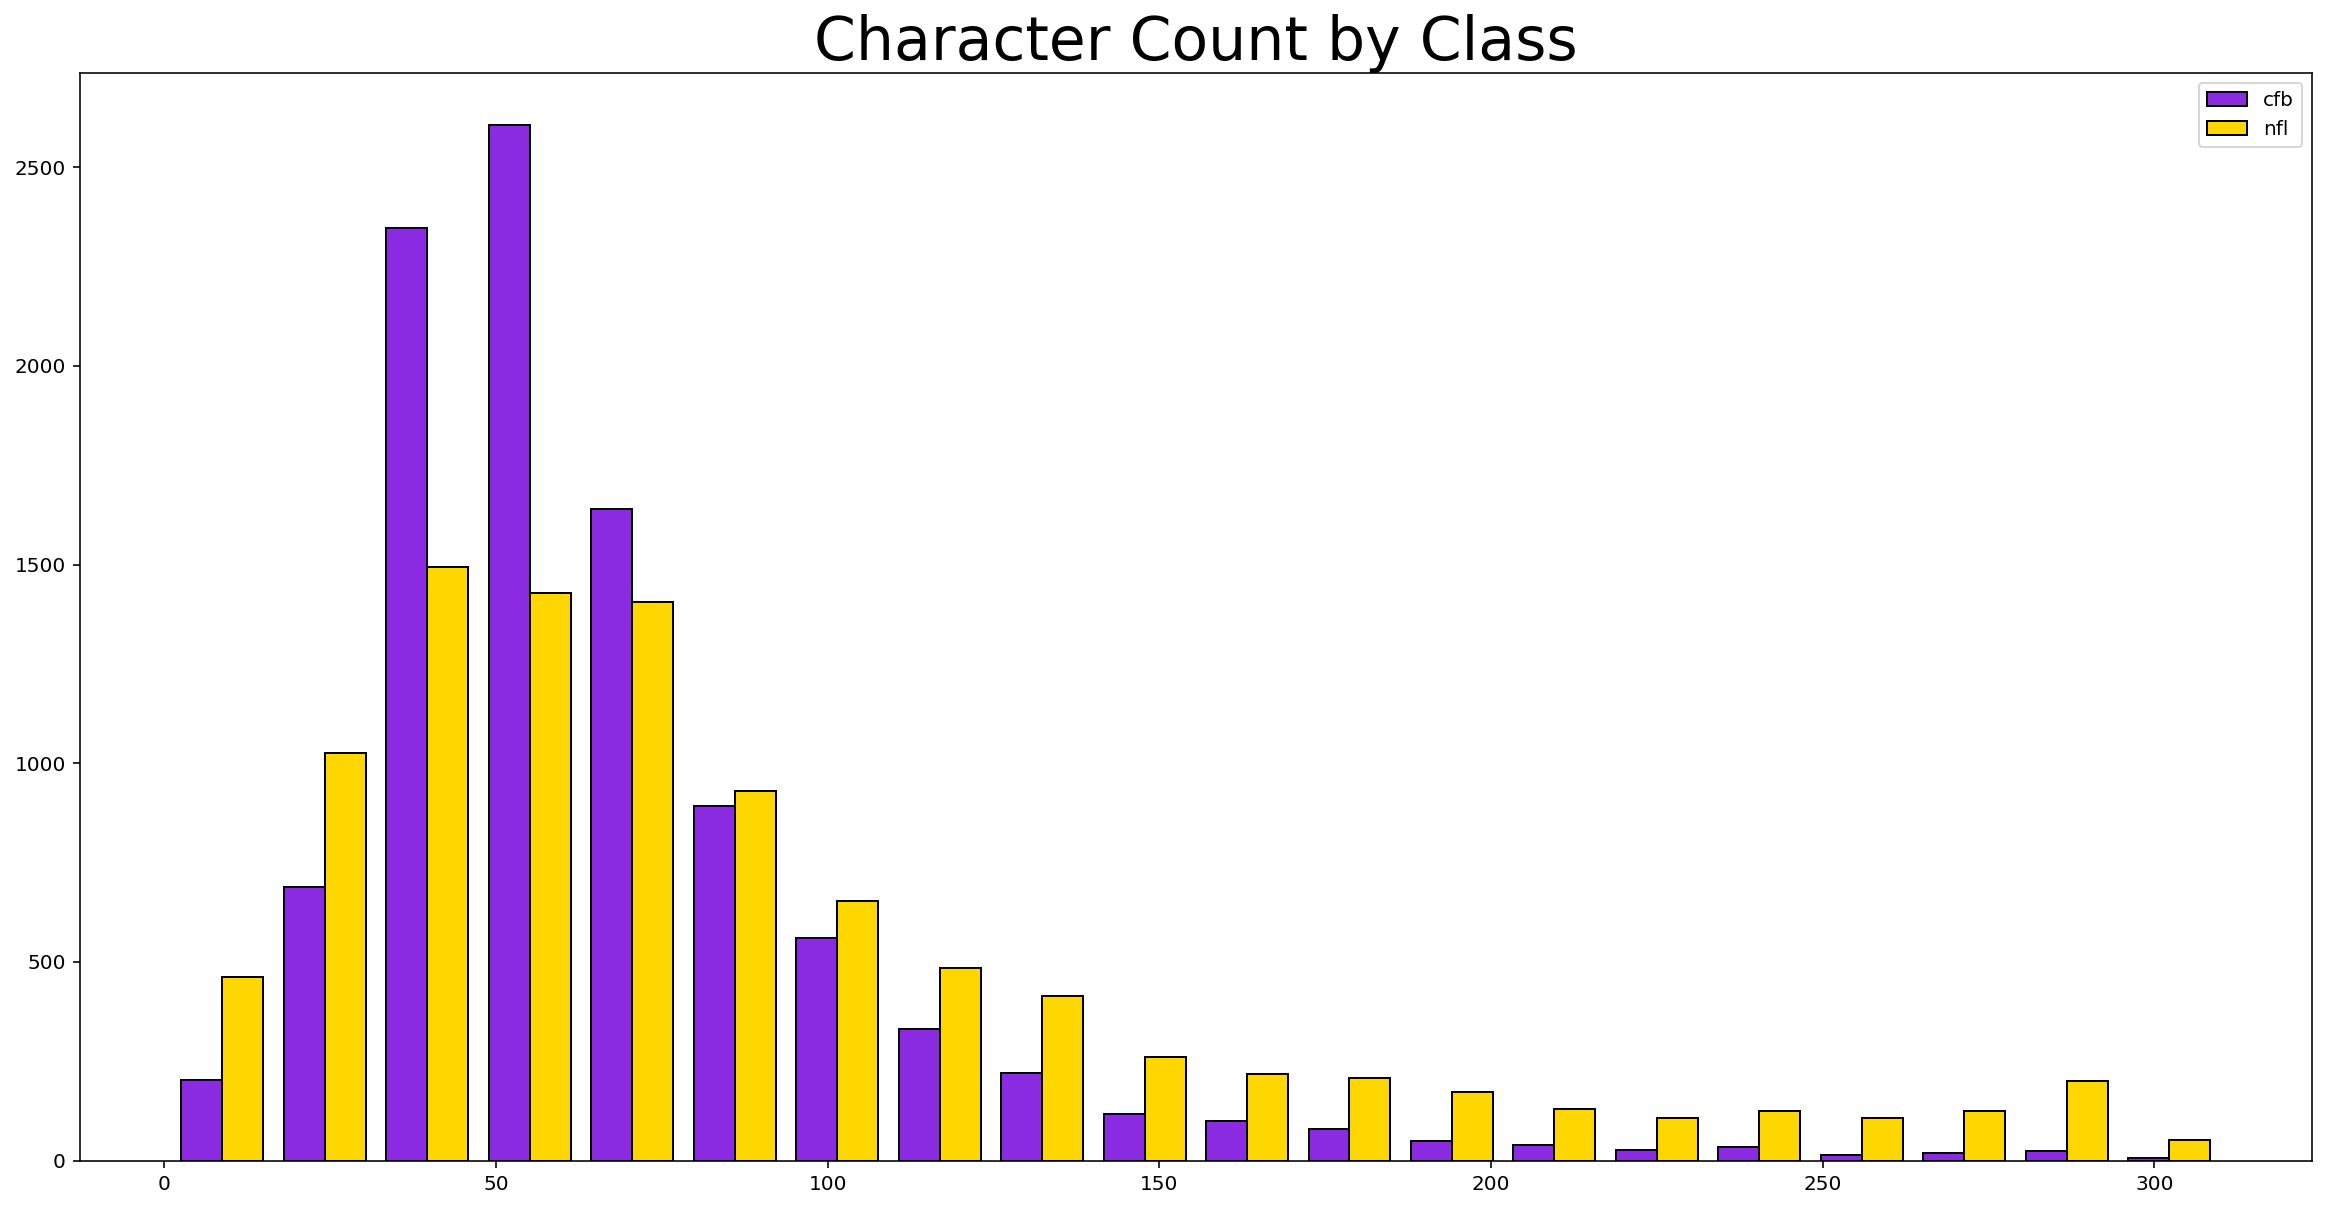

In [17]:
plt.figure(figsize=(20,10))
plt.hist([combined_df[combined_df['subreddit']==0]['char_count'], 
          combined_df[combined_df['subreddit']==1]['char_count']],
         bins=20, color=['blueviolet', 'gold'], ec='k')
plt.title('Character Count by Class', fontsize=30)
plt.legend(['cfb', 'nfl'])

plotting bar chart that compares cfb's and nfl's subreddits word counts

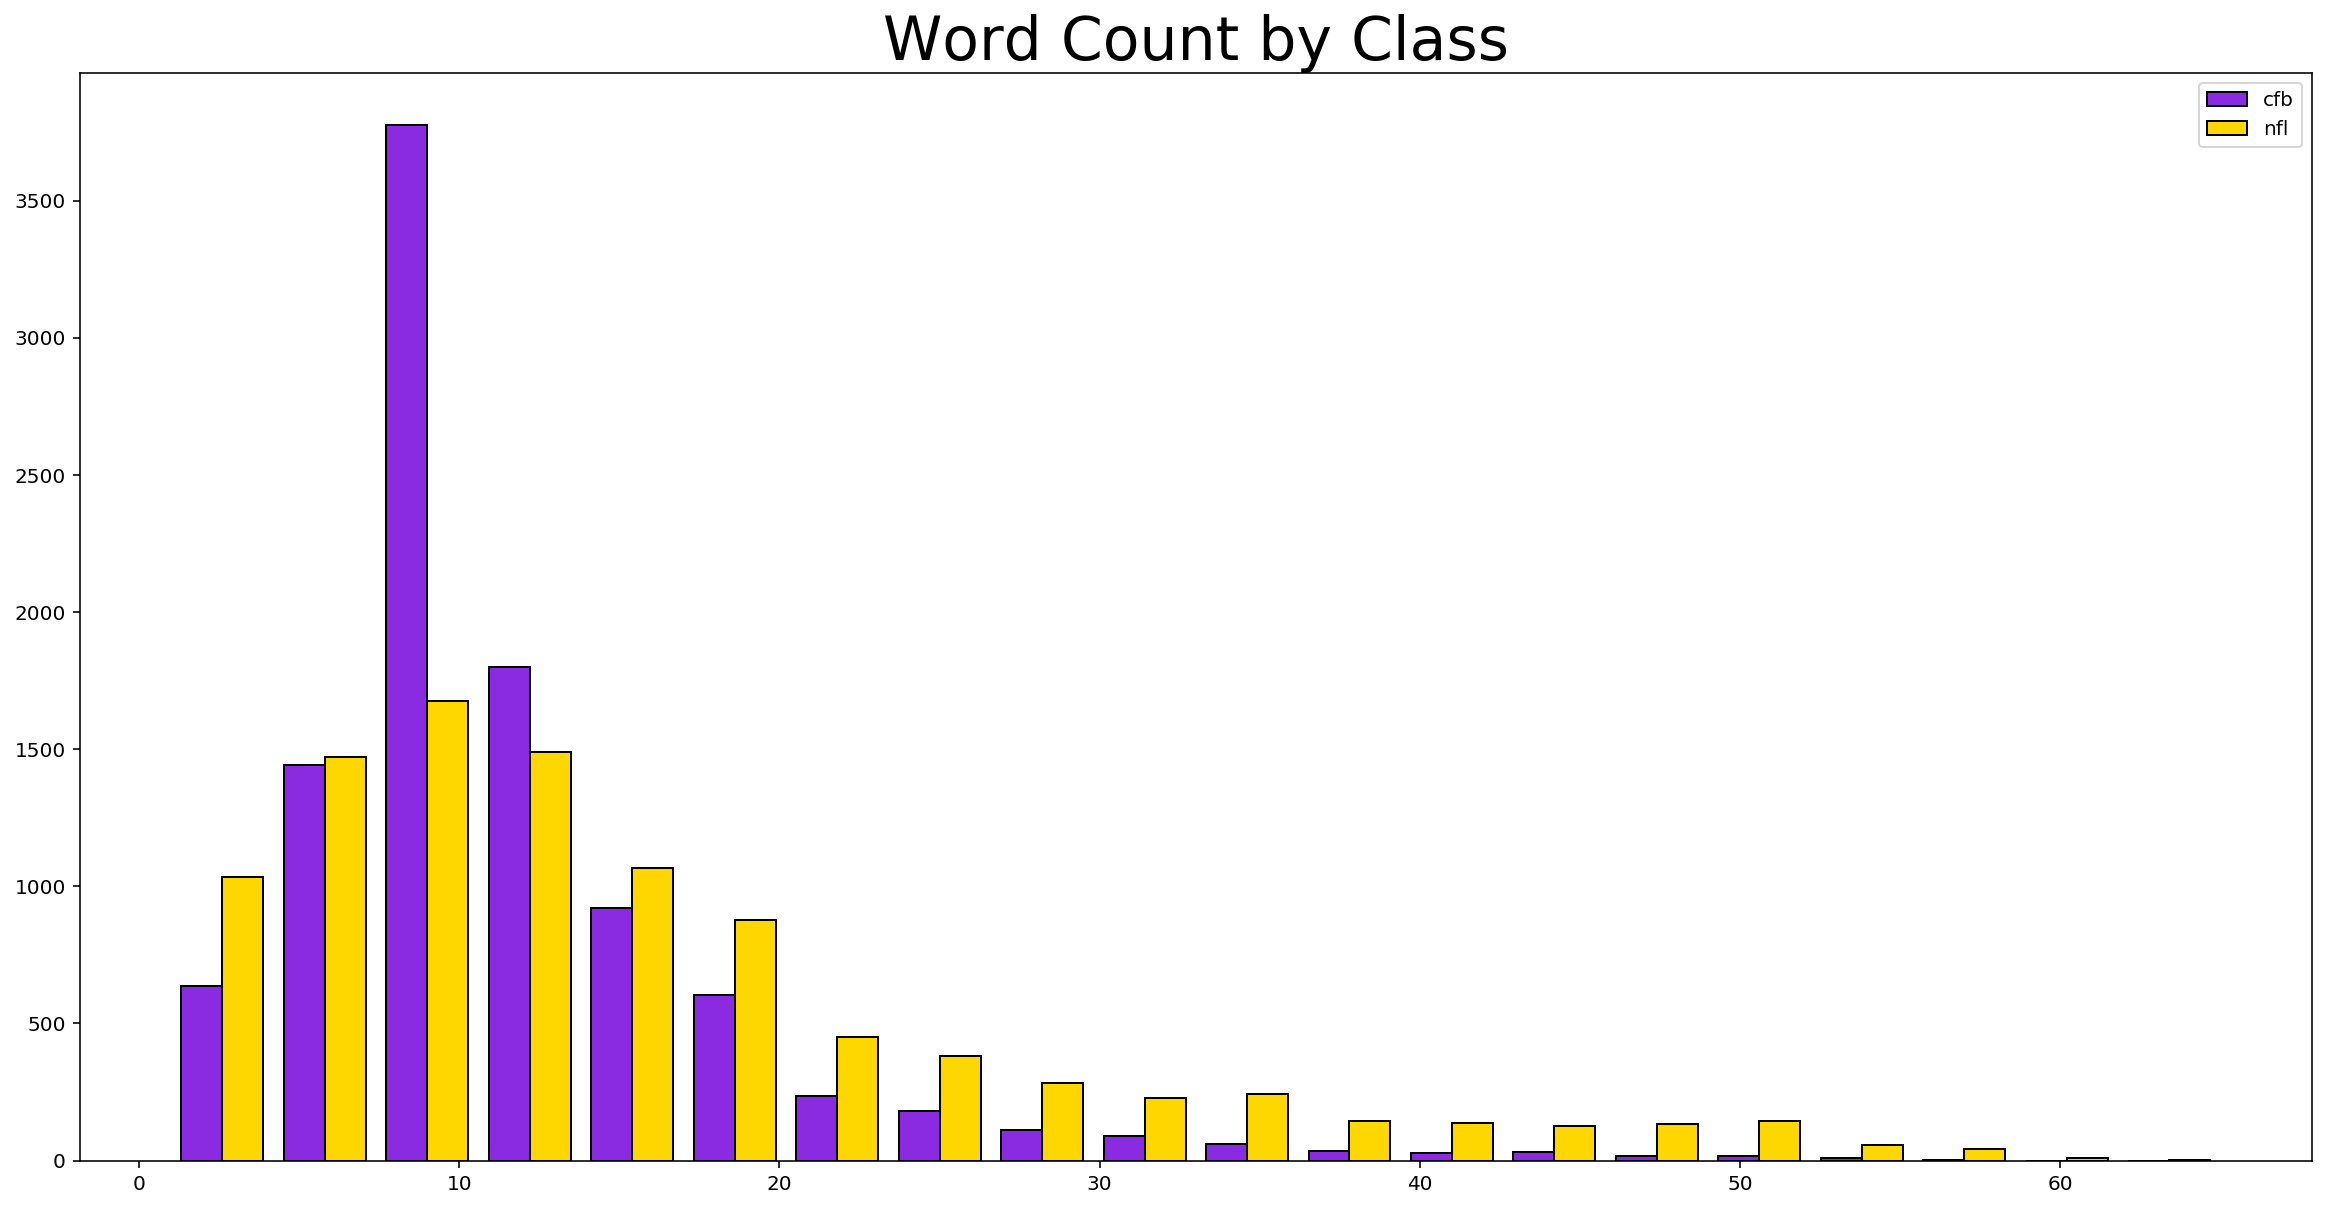

In [18]:
plt.figure(figsize=(20,10))
plt.hist([combined_df[combined_df['subreddit']==0]['word_count'], 
          combined_df[combined_df['subreddit']==1]['word_count']],
         bins=20, color=['blueviolet', 'gold'], ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.legend(['cfb', 'nfl'])

adding stop words that are obvious subreddit giveaways to nltk.corpus' english stopwords  

In [19]:
custom_stopwords = stopwords.words('english')

In [20]:
addtl_sw = ['lsu','college','nfl','super','chiefs','49ers','titans','ravens','clemson','mahomes','brady',
            'lamar','antonio','browns','packers','giants','alabama','cfb','oklahoma','tech','miss','oregon',
           'burrow','leach','usc','baylor','cfp','virginia','utah','big','senior','auburn','sec',
           'rutgers','mississippi','iowa','fsu','heisman','juco','school','kiffin','university',
           'lane','ncaa','nebraska','pac','jr','army','ucf','navy','recruiting','kentucky','notre',
           'dame','memphis','fau','saban','usf','helton','clay','tigers','orgeron','ed','osu','uga',
           'ou','pittman','purdue','maryland','ucla','hawaii','unlv','gt','appalachian','bowl',
           'commits','transfer','portal','brown','henry','patriots','aaron','vikings','rodgers','texans',
           'manning','afc','eli','nfc','tom','jimmy','derrick','cowboys','bill','panthers','seahawks',
           'garrett','bengals','superbowl','mvp','tannehill','eagles','jones','divisional','stefanski',
           'shanahan','george','reid','kyle','andy','bay','hof','raiders','kittle','broncos','luke',
           'wilson','ab','saints','kuechly','sb','contract','dolphins','peyton','kc','baltimore',
           'brees','jets','odell','mccarthy','garroppolo','mostert','colts','kelce','mcdaniels','bosa',
           'steelers','san','bills','beckham','sherman','rams','vrabel','lombardi','watson','belichick',
           'falcons','redskins','francisco','romo','russell','niners','franchise','wentz','hernandez',
           'england','raheem','xfl','chargers','brien','jaguars','watt','lions','cousins','shurmur','lafleur',
           'championship','texas','ohio','georgia','state','michigan', 'com', 'https', 'twitter', 'status', '10', '247sports', 
            'www', '12', 'redditcfb', 'would', 'made', 'source', 'removed', 'thread', 'amp','nbsp', '21', '11',
           'like','get','think','year','one','time','win', '00', '000', '00pm', '01', '010', '012', '015', '017', '01d', '02',
           '027', '03', '035', '03d', '04', '05', '06', '07', '075', '08','09', '100', '1000', '100k', '100th', '101', '1011', '102', '103',
           '104', '105', '106', '107', '108', '109', '10th', '110', '111', '112', '113', '114', '115', '116', '117', '118',
           '11th','120','121','123','124','125','126','127','128','129','12th','131','132','133','134','135','136','137','138','139','13th','140',
            '141','142','143','144','145','146','147','148','149','14th','150','1500','151','152','153','154','155','156','158','159','15th','161',
            '163','164','165','166','168','169','16th','170','171','172','175','176','177','178','179','17th','181','182','183','185','1869','187',
            '189','18th','190','191','1916','1919','192','1923','1925','1926','1929','193','1933','1934','1936','1938','1939','194','1940s','1941','1945',
            '1946','1948','1949','1950','1953','1957','196','1960','1961','1962','1963','1966','1967','1968',
            '1969','197','1970','1970s','1971','1972','1973','1974','1975','1976','1977','1978','1979','198',
            '1980','1980s','1981','1982','1984','1985','1986','1987','1988','1989','199','1991','1992','1993',
            '1994','1995','1996','1997','1998','19th','1pm','200','2000','2000s','2001','2003','2004','2005',
            '2006','2007','2008','2009','201','2010','2010s','2011','2012','2013','2015','2016','2017','2018',
            '202','2022','2023','2024','2025','203','2030','2031','204','205','206','207','208','209','20th',
            '210','211','212','213','214','215','217','218','219','21st','221','222','223','224','225','226',
            '227','228','229','230','231','232','233','234','235','236','237','238','239','23rd','240','241',
            '2411','243','245','246','248','249','24th','250','251','252','253','254','255','257','258','25th',
            '260','261','262','263','264','268','270','272','273','274','275','278','27th','282','283','284',
            '286','287','28th','292','293','294','29th','2k','2ot','2pm','301','303','304','305','306','307','308','30s','30th','310','311','312','313','316','31st','32','320','324','325','327','328','32nd','330','333','335','336','337','338','33rd','343','345','347','349','350','351',
            '352','353','354','355','356','358','359','36','362','364','365','368','370','374','375','377',
            '378','380','382','386','387','388','39','394','395','399','3m','3rd','40','400','402','403','413',
            '417','418','422','426','427','429','42nd','43','431','435','438','442','449','450','455','458',
            '459','460','462','464','47','475','480','482','484','488','492','495','4k','4pm','50','51','510','511','514','515','517','518','521','524','525','527','53','530','532','537','538','541','549','550','551','555','557','563','567','569','57','581','59','594','598','5m','5th','60','600','60s','61','610','615','62','620','625','629','63','632','637','642','65','650','667','672','68','69','690','6th','70','700','71','712','72','724','729','73','732','74','740','742','75','750','76','77','772','775','78','79','80','800','81','813','82','83','84','841','850','86','87','88','89','895','8th','90','900','91','911','916','92','93','94','95','96','98','99','9th','ability','able','aboard','abs','absence','absolute','absolutely','absurd','abysmal','accept','accepts','access','accident','accidentally','accolades','accomplish','accomplished','accomplishing','accomplishment','according','accordingly','account','accounted','accounts','accumulated','accuracy','accurate','accurately','accused','accuses','ace','achieve','achieved','achievement','achievements','achilles','acho','acknowledge','acknowledging','acquired','across','action','actions','activated','actively','activity','actual','adamschefter','adapt','add','added','adding','addition','additional','additionally','additions','address','addressed','addresses','addressing','adjusted','adjusting','adjustments','administration','admit','admits','admittedly','ado','adopted','adrian','ads','adult','advance','advanced','advances','advancing','advantages','adversity','advertising','advice','affair','affect','affected','affects','afford','aforementioned','afraid','african','afterward','ages','aggressive','aging','agree','agreed','ah','ahead','ahmad','aim','airport','aj','aka','ala','alan','alaska','albert','album','alcohol','alcornstate','alert','alex','algorithm','allegations','alleged','allegiant','allen','allow','allowing','almost','alone','along','alongside','alot','already','alright','alternating','alternative','although','altogether','alum','alvin','always','amari','amazed','amazing','amazingly','amazon','amendola','americans','amid','among','amount','amounts','analyst','analysts','analyze','analyzed','anchor','andersen','anderson','andre','andrews','andyslater','angelo','anger','angle','angles','angry','animation','anniversary','announce','announcer','announcers','announcing','annoying','annually','anonymous','answered','answering','anthony','anti','anticipation','antoine','anxiety','anymore','anything','anytime','anyway','anyways','anywhere','apart','apologies','apologize','apparel','apparent','appeal','appear','appearances','appeared','applied','applies','appreciate','appreciated','appreciation','approach','approaching','appropriate','approval','ar','arbitrary','arc','archie','archive','area','areas','argonauts','arguably','argue','argued','arguing','argument','arguments','arian','arik','arm','arms','armstead','aron','arrive','arrived','arriving','art','aside','asking','asks','aspect','aspects','assault','asses','assigned','assignments','assistant','assistants','assisted','associated','assume','assumed','assuming','astros','ate','athlete','athleticism','atlanta','atmosphere','att','attack','attacking','attacks','attempt','attempted','attempting','attend','attended','attending','attention','attitude','attractive','audible','audio','august','australia','australian','authorities','automatic','automatically','av','avenged','average','averaged','averages','averaging','avery','avg','avoiding','awake','awards','aware','away','awesome','awful','awhile','axe','babies','back','backed','backfield','background','backs','backup','backups','bad','badger','badly','baffling','bags','bailey','balance','balanced','baldwin','ball','balls','ban','bandwagon','banned','bar','barber','bare','barely','barnes','barnett','barring','barrow','barry','bars','base','baseball','based','bases','basic','basis','batted','battle','battles','bbq','beach','bear','beasley','beat','beaten','beathard','beating','beautiful','beavers','beck','becoming','bed','beef','beer','began','beginning','begun','behavior','behind','belief','believed','believes','believing','bell','belong','beloved','bench','benched','benchmark','benefit','benefited','benefits','bengal','bennett','benson','bent','bentley','bernie','berth','berths','besides','best','bet','bets','better','beyond','bias','biased','biases','bible','bielema','bienemy','bigger','biggest','billy','bird','birds','birth','birthday','bishop','bison','bit','bitch','bitter','bj','black','blackmon','blah','blair','blame','blames','blank','blast','blatant','blatantly','bleacherreport','bleed','bless','blind','blindsided','blitzed','blitzes','block','blocked','blockers','blocks','bloody','blount','blowout','blowouts','blows','blue','blueprint','blues','boards','boat','bob','bobby','bodies','bois','bold','bolded','bomb','bone','bones','bonus','book','books','boomer','boone','boost','boosters','boot','booth','border','borderline','born','boss','botched','bothered','bothers','bottle','bought','bounce','bounced','bound','bounds','bourbon','bowli','bowman','boxes','boxscores','boy','boys','br','brace','brad','bradford','bradley','brain','brainer','branch','brand','brandon','braxton','break','breakdown','breakdowns','breakout','breaks','breakups','brennan','bret','brian','brick','bricks','bridge','bridgewater','brief','briefly','bright','brilliant','bring','bringing','brings','brinson','britt','broadcast','broadcaster','broadcasting','broadcasts','brock','broke','bronze','brooks','bros','brothers','brought','browning','broyles','bruce','bruins','brutal','bryant','bs','btw','bu','bucket','bucks','bud','buddies','buddy','buffaloes','bug','build','building','builds','built','bull','bullet','bullshit','bully','bullying','bum','bump','bunch','burke','burning','burrows','burton','bus','bush','business','busts','busy','butker','butkus','butter','button','butts','buy','buying','buyout','buzz','byes','byron','cable','cadets','cake','calculated','caleb','calendar','calf','caliber','call','callaway','called','calls','calvin','cam','came','camera','cameras','cameron','camp','campaign','campanile','canada','canadian','cancel','cancelled','cancer','canned','cannon','cant','capable','capital','capitalize','capped','captain','captains','capture','cardinal','cards','care','cares','carlos','carmichael','carried','carrier','carriers','carries','carry','carrying','cartilage','case','cases','casey','cash','cast','casual','cat','catching','categories','category','catholic','cats','caught','causes','causing','cbs','ceiling','celebrate','celebrated','celebrates','celebration','celebrity','cemented','centennial','center','cents','century','ceo','certain','certainly','cfl','cg','chains','chair','challenged','championshiphttps','chance','chancellor','chances','chandler','changed','changes','changing','channel','chant','chants','chaotic','chapter','character','charged','charity','charles','charm','chart','charts','cheap','cheat','checkdown','checked','checks','cheer','cheering','cheers','cheese','cherry','chest','chief','child','childhood','children','chill','china','chips','choice','choices','choked','choking','choose','chooses','choosing','chose','chosen','chrome','chubb','chuck','chuckle','church','cigar','cincy','cinderella','circle','circulating','circumstances','cited','cities','claiborne','claim','claimed','claiming','claims','clara','clark','clash','classic','classy','clayton','cle','clean','clear','clearly','cleats','clem','click','cliff','climb','clinch','clinching','clint','clip','clips','clock','close','closed','closely','closer','closest','closet','closing','clothing','cloud','club','clubs','clue','co','coached','cobb','cocky','code','cody','coffee','cohen','coin','coincidence','coincidentally','cold','coleman','collapse','collar','collected','collection','collective','colleges','collins','color','colors','colt','columnist','columns','combination','combined','combo','combos','come','comebacks','comes','command','commemorate','commentators','commented','commercial','commercials','commissioner','committed','common','commonly','comp','companies','company','comparable','compare','compared','comparing','comparisons','compelling','compensate','compensation','compete','competed','competent','competing','competition','competitive','compilation','compile','compiled','compiling','complaining','complaint','complete','completed','completely','completes','completing','completion','complicated','comprehensive','comprised','computer','concept','concepts','concern','concerned','conclusion','concussion','concussions','condition','conditions','conf','confidence','confirmed','confusing','confusion','congrats','congratulations','congressional','connected','connection','connections','connor','cons','consecutive','consensus','consequences','consequently','conservative','consider','consideration','considered','considering','consist','consisted','consistency','consistent','consistently','consists','consolation','conspiracy','constant','constantly','contact','contacted','contain','container','containment','contemplating','contender','contenders','contest','contested','context','continue','continued','continues','continuing','contribute','contributing','contributions','control','controversy','conversation','conversations','conversion','conversions','converted','converting','convince','convinced','convincing','cool','cooler','coolest','coombs','coordinators','cop','copy','core','corn','corner','cornerback','cornerbacks','correctly','correlation','corresponding','cost','costello','costing','costly','costs','could','count','counted','counter','counting','countless','counts','couple','course','courtesy','courtland','cousin','coverages','covered','coveted','cowboy','cowherd','crab','crack','craft','craig','crap','crawford','craziest','crazy','cream','create','created','creates','creating','credit','credited','criminal','criteria','criticism','criticize','criticized','cromartie','cross','crossed','crossing','crow','crowd',
            'crowned','crucial','crushed','crushing','cry','crying','culpepper','culture','cummings','cumulative','cunningham','cupcake','curators','curious','curry','cursed','curtis','custom','cuts','cutting','cyber','cyrus','dad','daily','dale','damage','damn','dan','dana','dance','dancing','dane','danger','dangerous','danny','dante','dare','darius','darrell','database','dates','dating','daughter','davenport','david','dawkins','dawson','day','days','dbs','dc','dead','deadline','deadly','deal','deals','dealt','dean','deangelo','death','debut','dec','decades','decent','decide','decided','decides','deciding','decision','decisions','decisive','declaring','decline','declined','declines','dedicated','deep','deeper','defeat','defeated','defeating','defended','defender','defenders','defending','defenses','defensive','defensively','defined','defining','definitely','definition','definitive','deforest','degrees','deion','del','delaware','delay','delayed','delete','deleting','deliver','delivering','dellenger','delpit','demand','demands','demi','demon','demonstrated','demoted','denied','dennis','deny','department','depend','depending','depends','depot','derek','des','describe','described','describing','description','desert','deserve','deserved','deserves','deserving','deshawn','designated','designed','desire','desk','desmond','desperate','desperately','desperation','despite','destination','destined','destiny','destroy','destroying','detail','detailing','details','determine','determines','deuce','devastating','developed','developer','developing','development','device','devil','devonta','dexter','diagnosed','dick','dickerson','didnt','die','died','diet','diff','difference','differences','different','differential','differently','difficult','difficulty','dig','digit','digital','digits','dillon','dinner','dip','direction','directors','dirty','disagree','disappear','disappoint','disappointed','disappointing','disappointment','disaster','disastrous','discipline','disclaimer','discovered','discuss','discussed','discusses','discussions','disease','disgruntled','disguise','dislike','dislocated','dismal','disney','display','displayed','dispute','disqualified','disrespect','disrespected','disrupt','distance','div','dive','diversity','divided','divisions','divisonal','dixon','doak','doctor','documents','doesnt','dogs','dollars','dolphin','dome','dominance','dominate','dominated','dominates','domination','dominic','dominique','donation','donations','donnie','donovan','dont','dontae','donte','dooley','doomed','door','dorsett','dorsey','double','doubled','doubt','doubted','doubters','douglass','downed','downfield','downhill','download','downright','downtown','doyle','dr','drafts','drag','dragon','drake','drama','dramatic','drastically','draw','drawing','drawn','draws','dream','dreaming','dress','drill','drills','drink','drinking','drinks','drive','driven','drives','drivesdk','drop','dropped','dropping','drops','drought','drove','droy','drug','drugs','drum','drunk','dts','dual','duane','duck','dudes','dug','dumb','dumping','dunne','dunno','duo','duration','dust','dustin','duvernay','dwayne','dwight','dynamic','dynasty','eagle','earlier','earliest','earning','earns','earth','easier','easily','eason','easy','eat','eating','ebay','eclipsed','eddie','edge','edgerrin','edges','edits','education','effect','effective','effectively','effectiveness','effects','efficiency','efficient','effort','efforts','egregious','either','el','elbow','elected','element','elements','elevate','elevated','eleven','eliminate','eliminating','elimination','elliot','elliott','ellis','else','elsewhere','email','emails','embarrassing','embarrassment','emerge','emergence','emmanuel','emotional','emotions','emphasis','emphasize','employees','empty','emulate','en','end','ended','endless','endorsement','ends','endzone','energy','english','enjoyable','enjoyed','enjoying','enough','enrolled','ensuing','entertaining','entertainment','entirely','entry','environment','epenesa','episode','equal','equally','equipment','equivalent','erik','erin','error','errors','es','escapes','escaping','especially','espnpressroom','espnstatsinfo','esque','essay','essentially','est','establish','established','estimate','eugene','europe','evaluate','evaluated','evaluating','evan','evans','event','events','eventual','eventually','every','everybody','everyone','everything','everywhere','evidence','evident','evolution','exact','exactly','examine','examples','excel','excellent','except','exception','exceptional','exceptionally','exceptions','exchange','excited','excitement','exciting','excluded','excluding','exclusive','excuse','excuses','execute','execution','executive','exercise','exist','existed','existence','existing','exists','expanding','expansion','expect','expectation','expecting','expense','experience','experiences','expert','experts','expired','expires','explain','explained','explains','explanation','exploded','exploit','explore','exploring','explosion','explosive','exposed','express','expressed','extended','extending','extends','extensions','extensive','extent','extra','extremely','eye','eyes','ezekiel','faced','facemask','facemasks','faces','facing','fact','factor','factors','fail','failing','fails','failures','fair','fairbairn','fairly','faith','faithful','fake','falcon','fall','fallen','falling','falls','false','famers','familiar','family','famous','famously','fanatics','fanbase','fanbases','fans','fant','fantastic','fantasy','faq','far','fared','farewell','farthest','fascinating','fashion','faster','fastest','fat','fate','faulk','favor','favored','favorites','favors','fbi','fear','fearless','feast','feat','feature','featured','featuring','feb','feed','feedback','feeds','feel','feeling','feelings','feels','fees','feet','fell','fellow','felt','female','fewer','ff','fgs','field','fighting','figure','figured','figures','figuring','file','files',
'filled','filling','fills','film','finalized','finalizing','finally','finding','finds','finest','finished','finishing','finley','fire','firm','fish','fisher','fit','fits','fitz','fivethirtyeight','fixed','fixing','flag','flagged','flags','flashback','flashed','flashes','flashy','flat','flaws','fleming','flew','flight','flipping','flow','flowers','floyd','flu','fluke','flutie','fly','flying','fo','focus','focusing','foe','folks','follow','followed','fond','food','fool','footballoutsiders','footballs','forced','forcing','ford','foremost','forever','forfeit','forget','forgot','forgotten','form','formally','formation','formations','formed','former','formerly','formula','fort','forth','fortunately','fortune','forty','forward','foster','fought','foul','foundation','founded','fountain','fournette','fourth','fowler','fox','frame','frank','frankly','freaking','fred','free','freedom','freeman','frequently','fresh','freshmen','friction','friend','friends','frog','front','fronts','frustrated','frustrating','frustration','fs','ft','fuck','fucked','fullback','fuller','fully','fumbled','fumbles','fumbling','fun','funniest','funny','furious','furthermore','future','futures','fwiw','gabe','gain','gained','gaining','gakuin','gamble','gambling','gameplan','gametime','gap','gaps','garcia','gary','gas','gather','gatorade','gauge','gay','gee','gem','general','generally','generated','geno','genuine','genuinely','geoff','gerald','gesture','gestures','gets','gf','giant','gibbs','gift',
'gifts','gig','gimmick','giphy','girl','girlfriend','give','given','gives','giving','gl','glad','gleason','glory','gmail','gms','goal','goals','goats','god','gods','godwin','goes','gofundme','gold','golf','golic','gone','gonzales','goodbye','gordon','gore','gotten','grab','grade','grades','graduation','graham','grand','granted','graph','graphic','graphs','grass','grateful','gray','greater','greatly','greatness','greats','green','greg','grew','grey','gridiron','griffin','grind','groh','groin','groove','gross','ground','groups','grove','grow','growing','grown','guarantee','guaranteed','guaranteeing','guards','guess','guessed','guessing','guest','gun','gurley','guru','gut','ha','haha','hail','half','halftime','halves','ham','hamilton','hammer','hamstring','hand','handed','handful','handily','handing','handle','handled','handoff','hang','hanging','happen','happening','harbaugh','harder','hardest','hardly','harm','harold','harris','harrison','harry','hart','harvard','hash','hat','hate','hated','haters','hates','hatred','hats','haul','hawk','hawkins','hawks','hb','hc','hchttps','headed',
'heading','headline','headlines','heads','hear','heard','hearing','heart','heartbreak','heartbreaker','heartbreaking','heat','heated','heavily','heavy','heck','heels','height','heights','held','helicopter','hell','hello','helm','helmet','help','helped','helping','helps','hence','herd','hero','heroes','heroic','heroics','herring','hes','hesitate','hewitt','hey','heyward','hicks','hide','higgins','highest','highlighted','highly','highschool','hilarious','hindsight','hint','hip','hire','hired','hiring','historic','historical','hold','holder','holds','hole','holes','holmes','holmgren','holt','homage','home','homer','hometown','honest','honestly','honesty','honey','honor','honorable','honors','hood','hope','hoped','hopeful','hopefully','hopes','hoping','horrible','horrific','horse','hospital','host','hosted','hot','hotel','hotline','hour','house','houston','howard','however','hq','hue','huge','hughes','huh','human','humans','humble','hump','humphrey','humphries','hundreds','hunting','hurricane','hurry','hybrid','hyde','hyped','hypothetical','hypothetically','ian','ice','iconic','idea','ideal','ideally','ideas','identical','identified','identity','idiot','idk','ie','ignore','ignored','ignoring','ii','ilb','ill','illustrated','im','image','imagine','imagined','imgflip','imho','immediate','impact','impacted','impacts','implement','implementation','implemented','implementing','implications','importance','important','importantly','impossible','impressed','impression','impressive','improve','improved','improvement','improving','inability','inaccurate','inaugural','incapable','incident','included','includes','including','incoming','incompetence','incomplete','incompletions','inconsistent','incorrectly','increase','increased','increases','increasingly','incredible','indeed','index','indicated','indicates','individually','inductee','industry','indy','ineffective','ineptitude','inevitable','inevitably','infamous','inflated','influence','info','information','informed','ing','initially','injured','injuries','input','insane','insanely','insert','inside','insider','insiders','insight','inspiration','inspired','inspiring','instance','instances','instant','instantly','instead','institutions','insults','integrity','intelligence','intended','intense','intention','intentionally','interactive','intercepted','interception','interesting','interestingly','interference','internet','interviewed','interviewing','interviews','intrigued','intriguing','intro','introduce','introduced','introducing','introductory','invent','invest','investigated','investigation','investment','invitation','invited','involve','involved','involving','ios_app','iossmf','iq','ireland','irrelevant','isaac','ish','isnt','issue','item','items','iteration','iv','ivy','jacket','jackets','jackie','jacobs','jadaveon','jake','jamal','jameis','jan','japan','japanese','jared','javon','jax','jay','jc','jenkins','jennings','jeopardy','jeremiah','jeremy','jerome','jersey','jerseys','jesus','jet','jeudy','jim','jk','jo','job','jobs','jock','joe','joel','johnson','joined','joins','joint','joke','joked','jokes','joking','jon','jonathon','joseph','journal','journalist','journey','jovan','joy','joyner','juggernaut','juke','julius','jump','jumped','jumping','jumps','juniors','ka','kam','kamara','kan','kansascitychiefs','karma','keenan','keeping','keeps','kellen','kellerman','kelly','kelvin','ken','kendrick','kenny','kept','kerry','key','kicked','kicker','kickers','kicking','kickoff','kicks','kid','kids','kilgore','kill','killed','killing','kind','kinda','king','kiper','knees','knew','knife','knock','knocked','knocks','know','knowing','knowledgeable','known','knows','kordell','kr','ks','kudos','kwansei','labeled','laced','lack','lacking','lacks','ladder','lady','laid','lakers','lambeau','lame','land','landed','lands','landscape','lanes','lang','language','large','largely','larger','largest','las','lasted','lasting',
'lastly','late','lately','later','latest','latter','lattimore','laugh','laughed','laughing','laughs','laura','lavonte','lawyer','lay','laying','lazy','lbs','leader','leadership','leading','leads','leagues','leaked','lean','leaning','leap','learn','learning','leary','least','leaves','leblanc','lebron','legacy','legal','legally','legend','legendary',
            'legends','legion','legit','legitimate','legitimately','legs','len','length','leroy','less','lesser','lesson','lessons','lethal','lets','letters','levels','leverage','levi','lewis','lg','lie','lies','lifelong','lifetime','light','lightning','lights','liked','liking','limit','limited','limits','line','linebacker','linebackers','lined','linemen','lines','lineups','lining','linked','linval','list','listed','listen','listening','lists','lit','literal','literally','little','lived','lives','living','lmao','loaded','local','located','locations','locked','lockett','locks','logan','logic','logical','logically','logo','logos',
            'london','long','longer','longtime','look','looked','looking','looks','looms','loose','lopsided','lord','lose','loser','losers','losing','lott','loud','love','loved','loves','loving','low','lowest','loyal','loyalty','ls','lt','lucked','luckily','lucky','lure','machine','mack','maddox','magic','magical','magically','mail','main','mainly','maintain','maintained','maintains','majority','majors','make','makers','makes','malik','manage','managed','manager','manages','mania','manner','many','map','marc','march','marched','marching','margin','marine','mario','marion','mark','marketing','marks','marlon','marquez','marquise','married','mars','martin','marty','marvin','mary','mass','massachusetts','massively','matched','matches','matching','matchups','mateo','material','math','mathews','mathis','mattered','matters','matthew','matthews','maturity','max','maximum','maybe','mays','mcafee','mccaffrey','mccartney','mcclain','mccoy','mcdaniel','mcfarland','mcgee','mckenzie','mcknight','mcl','mclane','mcmahon','mcnair','mcshay','meal','mean','meaning','meaningful','meaningless','means','meant','meanwhile','measure','measures','meat','mechanics','medal','media','median','mediocre','mediocrity','meet','meets',
            'mega','meh','mel','melvin','member','members','meme','memo','memorable','memories','memory','men','mentality','mentally','mentioned','mentioning','mentions','mentor','merely','mess','message','messages','messed','meteor','meteoric','method','methodology','metlife','metric','metrics','meyers','michael','mick','mickey','midnight','midway','might','mighty','mil','mile','milk','miller','million','millions','minds','mine','mini','minimal','minimize','minimum','minkah','minneapolis','minnesotavikings','minor','minus','minute','minutes','misery','misses','missing','mistake','mistakes','mitchell','mix','mixed','mj','mo','mock','mocking','mod','model','modern','molly','mom','moment','moments','momentum','mon','money','montana','month','moon','moral','morgan','morton','mosley','moss','mostly','mother','motion','motivation','mov','move','moved','movement','moves','movie','moving','mph','mr','muddy','muffed','mullens','mulling','multi','murder','murphy','murray','muscle','muscles','mutually','myers','myles','nah','nail','naked','nashville','nate','nathan','nationwide','native','naturally','nature',
            'naval','navarro','nbc','nbcsports','near','nearing','nearly','neat','necessarily','necessary','needed','needless','needs','negative','negotiated','negotiations','neighbor','neil','neither','nelson','nerds','nerves','nervous','network','networks','nevertheless','new','newer','newton','nextgenstats','ngata','nice','nicely','nick','nickel','nickname','night','nightmare','nights','nike','nine','niner','ninth','nissan','nixon','noah','nobody','nod','noise','nola','nolan','nomination','nominations','none','nopd','nope','norm','normal','normally','norman','northeast','norwood','nose','notable','notably','note','noteworthy','nothing','notice','noticed','noting','nov','nova','nowhere','nsfw','nt','number','numbers','numerous','nuts','nutshell','ny','nyc','oak','objective','objectively','observation','observations','obvious','obviously','occasion','occasionally','occasions','occurred','occurs','ocs','oct','october','offense','offenses','offensive','offensively','offer','offered','offering','offers','office','officers','official','officials','officiating','oil','oj','ok','okay',
            'old','oldest','oline','olson','ones','ongoing','onion','online','onside','oof','open','opened','opener','opening','openings','openly','opens','operating','operations','opinion','opinions','opp','opportunities','opportunity','opposite','opt','optimism','optimistic','options','opts','ordered','organizations','organized','oriented','origin','original','originally','orleans','orlovsky','orton','ot','others','outcome','outcomes','outdated','outgained','outlets','outlier','outliers','outplayed','outrun','outs','outside','outstanding','outta','overall','overcome','overcoming','overdue','overlooked','overrated','overthecap','overtime','overturn','overturned','overwhelmed','owens','owned','owns','ozzy','pace','pacific','pack','package','packages','pads','paid','painful','paint','painted','pair','pairing','panther','pants','papa','paper','par','parade','pardon','parent','parentheses','paris','parity','park','parker','parking','parted','participant','participated','participating','participation','particular','particularly','parties','parting','partly','partner','parts','passed','passion','passionate','past','path','pathetic','patience','patriot','pattern','paul','pavilion','pay','payed','paying','payment','pbs','pct','pd','peak','pearson','peat','peek','penalties','penalty','pending','penei','peoples','peppers','per','percent','percentage','perception','perennial','perfect','performance','performances','performed','performing','perhaps',
            'periods','permanent','permanently','perry','person','personalities','personality','personally','personnel','peter','peters','peterson','pettis','petty','pftcommenter','phenomenal','phenomenon','phil','phillips','philosophy','phone','photo','photographer','photoshop','physical','physically','pi','pic','picked','pickem','picking','pickup','pics','picture','piece','pieces','pierce','pierre','pile','pink','pirates','piss','pissed','pitch','pizza','pk','placement','places','placing','plagued','plan','plane','planet','plans','plant','playcalling','played','players','playing','playmakers','playoff','plays','plenty','plot','plug','plus','pn','png','pocket','point','pointed','pointing','points','poised','political','politics','poor','pop','pope','popped','popping','pops','popular','population','portion','portland','pos','positions','positive','possess','possession','possessions','possibilities','possibility','possible','possibly','poster','posters','posting','posts','potential','potentially','potter','potty','pouncey','pound','pounds','powered','powerful','powerhouse','ppg','pr','practically','practice','practices','practicing','praise','praises','prater','pre','predictable','predicted','predicting','prediction','predictions','predicts','prefer','preference','preferred','pregame','prep','preparation','present','presentation','presented','presents','president','press',
            'presser','pressure','pressured','pressures','prestigious','preston','presumably','pretend','pretty','prevent','preventing','previously','price','prices','pride','primarily','prince','principle','prior','priority','private','probability','probably','probe','proceed','proceeded','proceeds','process','produce','produced','producing','product','productive','profanity','professional','profiles','profit','progress','progression','project','projecting','projects','prolific','prominent','promise','promised','promising','promote','promoting','promotion','prompted','prone','prop','propelled','properly','proposal','propose','props','pros','prospects','protection','proud','proved','proven','provides','providing','proving','psa','pt','public','publicly','published','pulled','pulling','pulls','pumped','punched','punches','punching','punished','punted','punter','punters','punting','purchase','purchased','pure','purple','purpose','purposely','purposes','pursue','push','pushed','pushing','put','putting','pylon','qb1','qbr','qualified','qualifies','qualifying','quality','quan','quantity','quarter','quarterback','quarters','queen','quickly','quiet','quietly','quinn','quinton','quit','quite','quotations','quote','quotes','race','racial','racist','radar','raid','rain','raise','rake','rallied','ralph','ramsey','ranch','randall','randle','random','randy','range','ranks','rant','rare','rarity','rashaan','rashad','rashod','rate','rather','ratio','rattled','raw','ray','raymond','reaches','reaching','react','reaction','reactions','reacts','read','reading','reads','ready','real','realignment','realistic','realistically','reality','realize','realized','realizes','realizing','really','realm','reason','reasonable','reasoning','rec','recall','receive','received','receiver','receivers','receives','recency','recent','recently','reception','receptions','recieving','recipe','recognition','recognize','recognized','recognizes','recommend','recommended','recorded','recording','records','recover','recovered','recovers','recovery','red','redd','redditors','redemption','reduce','reduced','redzone','reed','reese','reeves','ref','refer','referee','referees','refers','reflecting','reflects','refrain','refused','refuses','regain','regard','regarded','regards','reggie','regime','region','regional','regions','registering','regress','regret','regular','regularly','regulation','reign','reigning','related','relationship','relationships','relative','relatively','release','released','relegated','relevance','relevant',
            'reliable','relied','relief','relieved','religion','rely','relying','remain','remained','remaining','remarkable','rematches','remembered','remembering','remembers','reminded','reminder','remotely','removes','removing','rename','rendering','renders','renfro','rep','repeat','repeatedly','repeating','replaced','replacement','replacements','replay','replica','replies','reply','reported','reporters','represent','representation','representative','representatives','represented','representing','reputation','requests','required','requirement','requirements','requires','reserve','reset','resign','resigned','resources','respectable','respectful','respective','respectively','respond','responds','response','responses','responsibility','responsible','rest','restaurant','resulted','resume','resumes','retain','retaining','returned','returner','returns','reuben','reveal','revealed','revenge','reverse','reversed','reviewed','reviewing','reviews','revisit','rewarded','rewards','rewatch','reynolds','rhule','rhythm','rib','ribs','rich','richardson','rick','rid','ride','ridiculous','ridiculously','riding','riggins','right','rightfully','rightly','rights','rio','rip','rips','rising','risk','risks','rival','rivals','river','rn','road','rob','robbed','robbie','robby','robert','roberts','robertson','rodney','role','roles','roll','rolling','rolls','ron','ronald','ronnie','roof','rookies','room','roosevelt','root','rooting','roots','rosen','roster','rosters','rotated','rotating','rotation','rough','roughly','rounder','rounders','rounds','routine','routinely','row17','rpo','rs','rub','ruggs','ruin','ruining','ruiz','rulebook','ruled','ruling','rumblings','runner','runners','runs','rushed','rusher','rushers','rushes','russ','russel','rust','rutter','sacked','sacrifice','sad','safe','safeties',
            'safety','saga','saint','sake','sale','sales','salisbury','sallee','salty','sample','samuel','samuels','sanchez','sanctions','sanders','santa','sat','satisfied','satisfying','saturdays','savage','savings','saw','sbnation','scale','scam','scandal','scar','scared','scenario','scenes','scheme','schemes','scherff','science','scientists','scoreboard','scoreless','scores','scorigami','scoring','scot','scout','scouting','scramble','scrambles','screaming','screen','screencaps','screwed','scrimmage','script','sd','seal','sealed','search','searching','seasons','seasonthe','seat','second','secondary','secondly','secret','section','secure','secured','secures','security','see','seed','seeds','seeing','seek','seeking','seeks','seem','seemed','seems','seen','sees','select','selected','selection','selections','self','sell','selling','send','sending','sends','seniors','sent','sentence','sentiment','separate','separated','separation','sept','september','serious','seriously','serve','served','service','services','serving','session','sets','setting','settle','settled','setup','seventh','several','severe','sewell','sex','sexual','sh','shade','shadow','shake','shakeup','shall','shannon','shape','shaq','share','shared','shed','sheer','sheet','sheets','shell','shenault','sherm','shift','shining','ship','shirt','shirts','shits','shitty','shock','shocked','shocking','shoot','shooting','shootout','shore','shortly','shot','shots','shoulders','shout','shoutout','show','showdown','showed','shown','shows','shut','shutout','shuts','shutting','shy','sick','side','sided','sidelines','sight','signals','signature','signed','significant','significantly','silence','silly','silver','similarities','similarity','similarly','simmons','simple','simplified','sims','simulated','simultaneously','since','sincerely','sing','singing','single','singletary','sister','sits','sitting','situations','sixth','size','sized','skill','skin','skit','skits','sky','slant','slants','slap','slate','slated','sleep','sleeper','slept','slew','slide','slight','slightly','slim','sling','slipped','slot','slow','slowly','smaller','smallest','smalls','smart','smashed','smile','smith','smoke','smoked','smoking','snapping','sneak','snippet','snow','soccer','social','society','sofi','soft','sold','solely','solid','solomon','solution','solve','somebody','somehow','something','sometime','sometimes','somewhat','somewhere','son','song','songs','sons','soon','sophomore','sorry','sorta','sorts','sos','sought','soul','sound','sounds','soup','southwest','space','span','spans','spark','spartan','speaking','speaks','special','specialist','specific','spectacular','spectrum','speculation','speech','speeds','spend','spending','spent','spin','spiral','spirit','spit','spite','split','spoiler','spoilers','spoke','spoken','sponsors','sport','sportingnews','sportscenter','spotify','spotrac','spotted','spotting','sprain','sprint','sproles','spurrier','spy','squad','square','sr','stack','stacked','staffs','stage','stagg','stake','stakes','stan','stand','standard','standards','standing','standout','stands','stanley','stapleton','staring','start','starter','starters','starts','stated','stating','station','statistic','statistical','statistically','statistics','stayed','stays','stc','steady','steak','steal','stealing','steals','stellar','step','stephen','stepping','steps','sterling','steve','steven','stevens','stick','stickers','sticking','sticks','still','stills','stint','stints','stock','stole','stone','stood','stopped','stops','store','storied','stories','story','storyline','storylines',
            'stout','straight','strange','stranger','strategy','streamable','streaming','streams','street','strength','stretch','strictly','stride','strike','string','stripes','stroke','stronger','strongest','strongly','struck','structure','struggled','struggles','struggling','stuck','stud','studies','studio','study','stuffed','stunning','stupid','style','styles','sub','subdivision','subject','subjective','submission','submissions','submit','subreddit','subs','subscribers','substance','substantially','subtle','succeed','success','successfully','successor','suck','sucked','sucks','sudden','suddenly','sued','suffering','suggested','suggestion','suggests','suggs','suh','sullivan','sum','summarize','summary','summer','sums','sunshine','superior','superman','superstar','support','supporter','supporting','suppose','supposed','supposedly','sure','surely','surpass','surprise','surprises','surprising','surprisingly','surrendered','surrounding','survey','survive','surviving','suspect','suspensions','sutton','swear','sweep','sweet','swing','switched','switching','sympathy','symptoms','table','tables','tackled','tackler','tag','tailgating','tailored','tajae','take','takeaways','taken','takes','taking','tale','talent','talented','talents','talks','tank','tape','target','targeted','tarik','task','taste','taught','taxes','tbd','tbh','teach','teacher','teammate','teammates','tear','tearing','tears','tebow','technical','technically','technique','technology','ted','teddy','teen','televised','television','telling','tells','temperature','temporary','tend','tendency','tenn','tennesseetitans','tens','tenure','term','terms','terrible','territory','terry','test','testaverde','tested','testing','tests','texan','text','tfl','th','thaddeus','thank','thankfully','thanks','thats','theater','theme','themed','theory','therefore','theres','thick','thier','thin','thing','things','thinking','thinks','third','thirty','tho','though','thought','thoughts','thousand','thousands','threat','threatening','threatens','threats','threshold','thriller','thrilling','thrive','throat','throughout','throwback','throwing','thrown','thru','thumb','thus','ticket','tickets','tie','tiebreaker','tied','tiers','tightly','til','till','timeline','timeout','timeouts','times','timing','tiny','tip','tipped','tips','tired','titled','tl','tldr','tm','tmz_sports','todd','toe','together','told','tommy','tomorrow','tonight','tons','took','tools','topic','tops','tore','toronto','toss','totally','touch','touchback','touchdown','touchdowns','touched','touches','tough','tougher','toughest','tour','touted','toward','towards','toyota','trace','track','tracked','tracking','tracks','trademark','trades','traditions','traffic','tragedy','trail','trailer','train','trainer','trainers','training','traits','trajectory','transition','travel','traveled','travels','tre','treat','treated','treatment','tree','tremendous','trenches','trending','trends','tribune','tribute','trick','tried','triggered','trim','trinity','trio','trip','triplett','trips','tristan','trolling','trolls','troubled','truck','true','truly','trump','trust','truth','try','trying','tryout','tuck','tucker','tune','tuned','tunsil','turf','turnaround','turned','turner','turning','turnover','turnovers','turns','tutorial','tweets','twelve','twenty','twice','twimg','twist','twists','two','ty','tylan','typical','typically','tyree','tyrell','udfa','ufc','ugly','uh','ultimate','ultimately','ultra','um','unable','unanimous','unaware','unbiased','uncle','uncommon','underdog','underdogs','underneath','understand','understanding','understood','underwent','undoubtedly','unexpected','unfairly','unforgettable','unfortunately','uniform','uniforms','unique','unis','unit','unitas','united','units','universe','unless','unlike','unlikely','unlucky','unnecessary','unofficial','unofficially','unpopular','unprecedented','unpredictable','unprepared','unreal','unrelated','unsportsmanlike','unsuccessful','unusual','updates','updating','upfield','upload','upon','upset','upsets','upvote','upvotes','usage','useful','useless','users','using','usual','utilized','utm_name','utter','vacancies','vacant','vacated','vacation','vague','value','values','van','vance','vander','various','varsity','vast','vegas','vehicle','venue','verge','verizon','vernon','versa','versatile','version','vertical','veterans','vi','via','viable','vice','victories','victory','video','viewed','viewership','viewing','vince','vincent','vinny','vintage','violating','violation','violence','violent','viral','virtually','vision','visits','visual','visualization','vital','voice','void','volume','voted','voters','voting','wac','waddle','wade','wads','wagner','waited','waiting','waivers','walk','walking','walks','wall','wallace','walsh','wanna','want','wanted','wanting','war','ward','ware','warm','warmups','warning','warren','warriors','wars','washed','waste','wasted','watched','water','waters','watts','way','wayne','ways','weak','weaker','weakest','weakness','weapon','wear','wears','weaver','web','webp','website','websites','wednesdays','weed','weekend','weeks','weigh','weighted','weinke','weird','welch','welcome','welcomed','well','wells','went','wesley','westbrook','whats','whatsoever','wheel','wheels','whenever','whereas','wherever','whether','whichever','white','whitman','whopping','whose','whoseline',
            'wide','widely','wiki','wikipedia','wildcat','wildly','william','williams','williamson','willing','windows','winds','winfield','wing','wingo','wings','winning','winningest','wire','wirfs','wise','wishes','within','without','witness','woah','wolf','women','wondered','wonderful','wondering','wont','wood','woods','woodson','woody','word','words','work','worked','working','workout','works','worried','worse','worst','worth','worthy','wrap','wrapped','wreck','wrist','write','writers','writing','written','wrong','wrote','wtf','wyatt','x200b','ya','yahoo','yale','yall','yard','yardage','yarder','yea','yearly','yell','yelled','yellow','yes','yesterday','yet','yikes','yoda','young','younger','youngest','youth','youtu','youtube','ypc','ypg','zac','zebras','zero','zeroing','zips','zone','zones','zoo',
]

In [21]:
for word in addtl_sw:
    custom_stopwords.append(word)

resetting index so it is all unique

In [70]:
combined_df.reset_index(inplace=True)

replacing all title & selftext nans with 'DeLEeT'

In [71]:
combined_df['selftext'].replace(np.nan,'DeLEeT', inplace=True)

In [72]:
combined_df['title'].replace(np.nan,'DeLEeT', inplace=True)

removing all \n's

In [73]:
combined_df['selftext'] = combined_df['selftext'].str.replace('\n','')

In [74]:
combined_df['title'] = combined_df['selftext'].str.replace('\n','')

combining titles and selftexts

In [75]:
combined_df['merged'] = combined_df['title'] + combined_df['selftext']

removing all 'DeLEeT's

In [76]:
combined_df['merged'] = combined_df['merged'].str.replace('DeLEeT','')

instantiating sentiment intensity analyzer (sia) object, creating function to obtain sentiment scores, applying this function to all merged text

In [30]:
sia = SentimentIntensityAnalyzer()

In [31]:
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

In [32]:
combined_df['sentiment'] = combined_df['merged'].apply(get_compound_sentiment)

groupby to determine which subreddit is more positive

In [33]:
combined_df.groupby('subreddit')['sentiment'].mean()

subreddit
0    0.098117
1    0.095647
Name: sentiment, dtype: float64

plotting distribution of sentiment scores for cfb and nfl subreddits

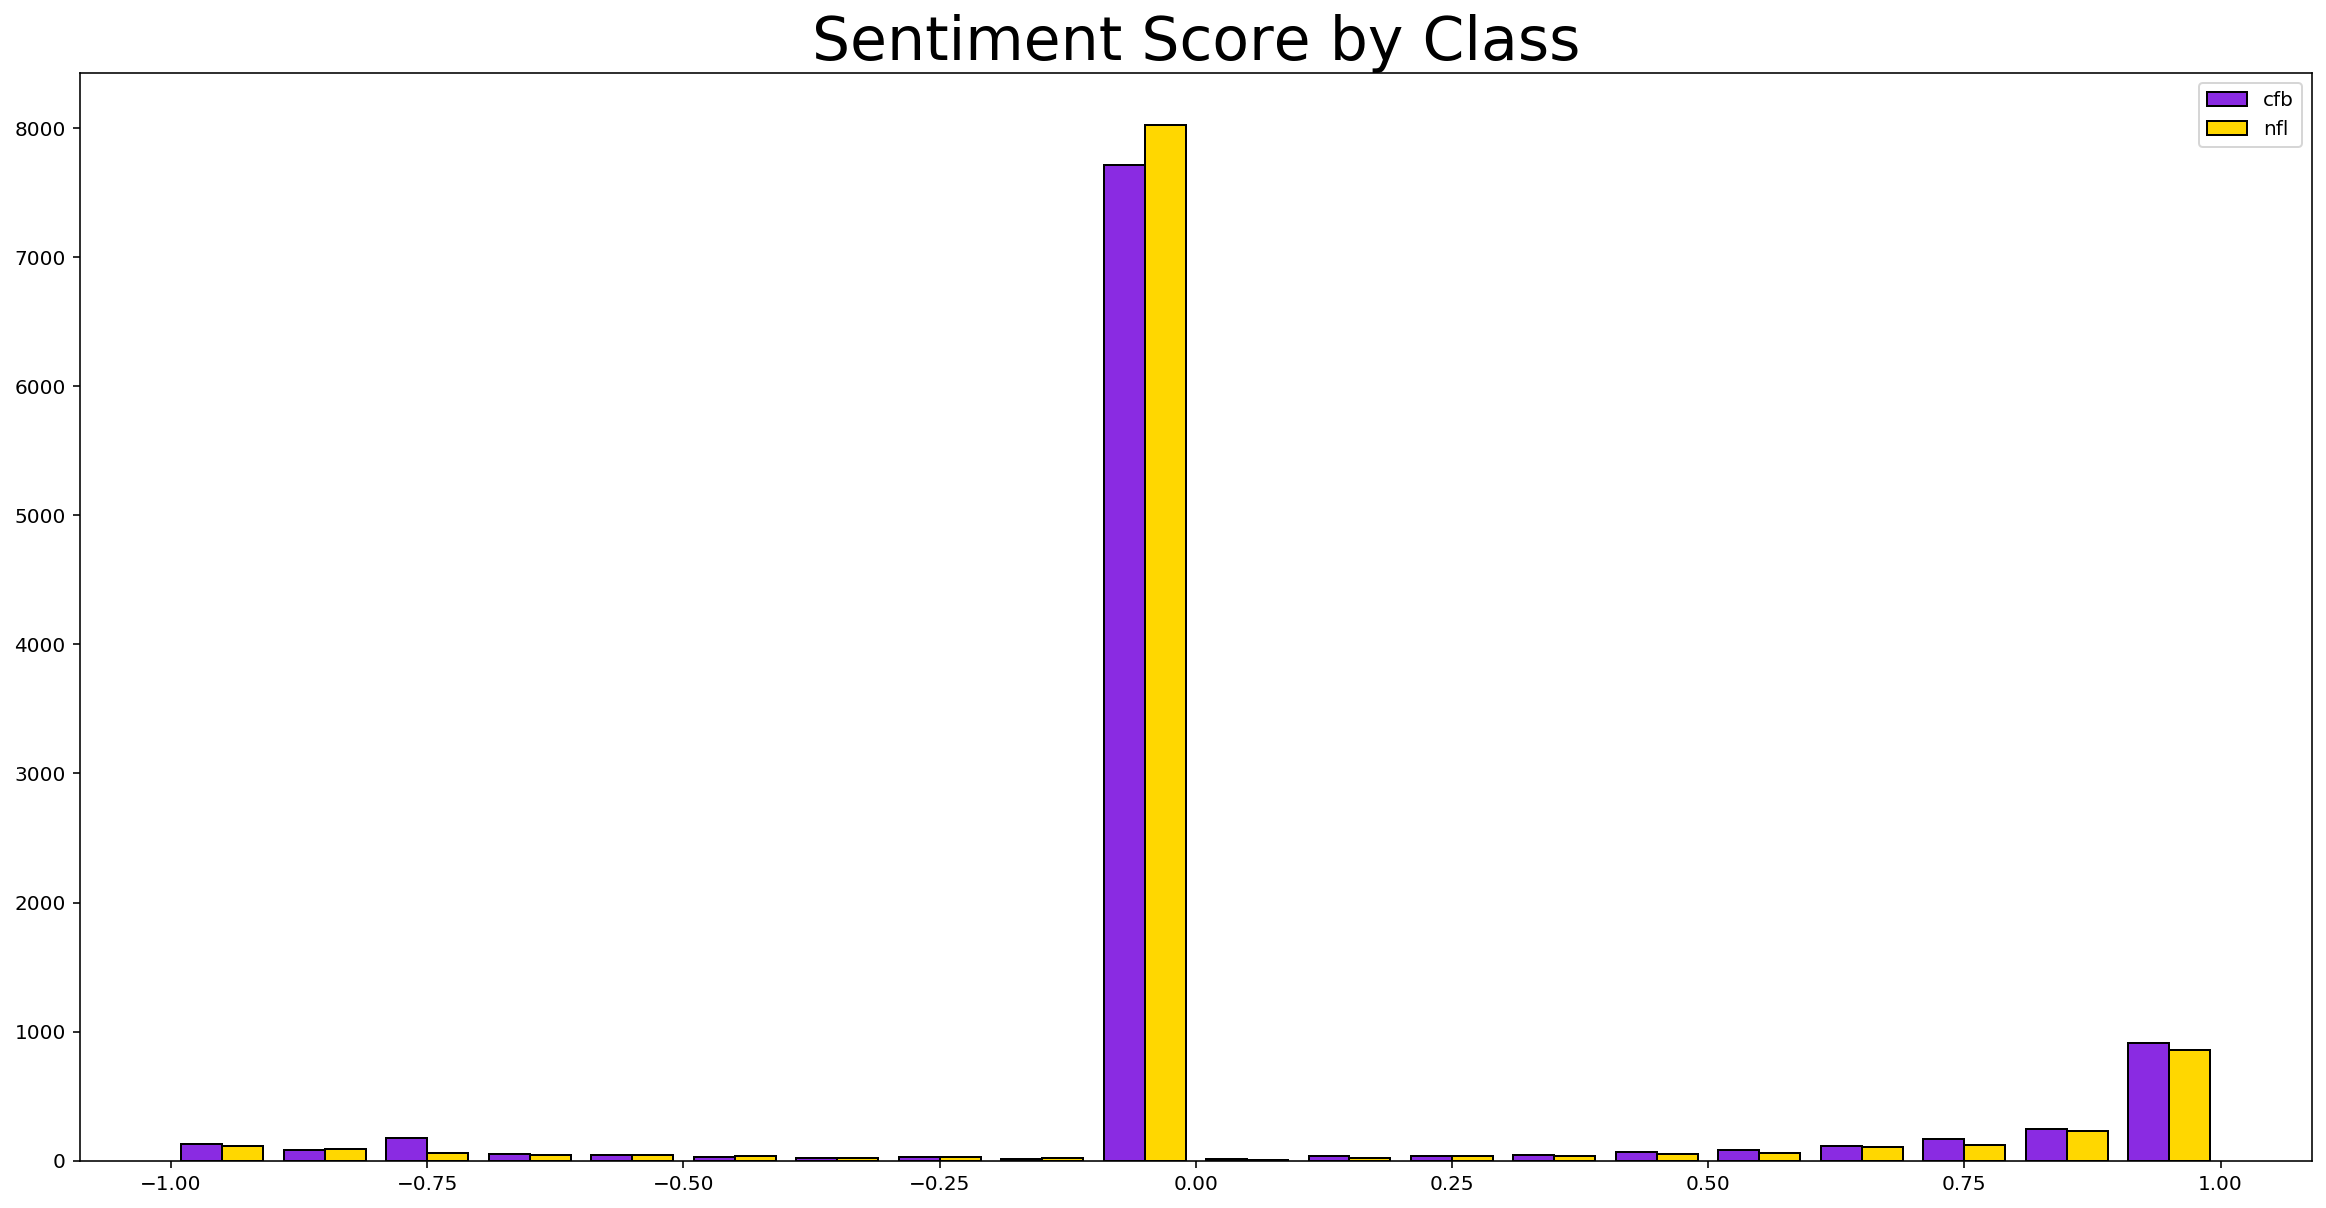

In [34]:
# distribution of the composite sentiment score
plt.figure(figsize=(20,10))
plt.hist([combined_df[combined_df['subreddit']==0]['sentiment'], 
          combined_df[combined_df['subreddit']==1]['sentiment']],
         bins=20, color=['blueviolet', 'gold'], ec='k')
plt.title('Sentiment Score by Class', fontsize=30)
plt.legend(['cfb', 'nfl'])

exporting combined dataframe to csv, so new data isn't pulled everytime notebook is run

In [77]:
combined_df.to_csv('combined_df.csv')

instantiating, fitting, and transforming cvec object

In [36]:
cvec = CountVectorizer(stop_words=custom_stopwords, min_df=5, max_df=1.0)

In [37]:
term_mat = cvec.fit_transform(combined_df['merged'])

creating dataframe of post transformed data

In [38]:
term_df = pd.DataFrame(term_mat.toarray(), columns=cvec.get_feature_names())

inserting target column to dataframe containing transformed data

In [39]:
term_df.insert(0, 'sr_target', target.values)

doing groupby for means of most common words in cfb posts juxtaposed against means for the same words from nfl posts

In [40]:
term_df.groupby('sr_target').mean().T.sort_values(0, ascending=False).head(20)

sr_target,0,1
player,0.4997,0.1052
game,0.4715,0.2846
team,0.3319,0.2523
season,0.3302,0.1752
football,0.2946,0.0683
2019,0.2489,0.0604
teams,0.2450,0.1310
vs,0.2358,0.0712
week,0.2233,0.0533
post,0.1938,0.0495


doing groupby for means of most common words in nfl posts juxtaposed against means for the same words from cfb posts

In [41]:
term_df.groupby('sr_target').mean().T.sort_values(1, ascending=False).head(20)

sr_target,0,1
game,0.4715,0.2846
team,0.3319,0.2523
season,0.3302,0.1752
teams,0.2450,0.1310
first,0.1235,0.1114
yards,0.0818,0.1088
player,0.4997,0.1052
qb,0.0668,0.1043
pro,0.0056,0.0929
play,0.1308,0.0879


saving groupby to see which words were more prevalent in nfl subreddit compared to cfb subreddit

In [42]:
nfl_words = term_df.groupby('sr_target').mean().T.sort_values(1, ascending=False)

In [43]:
nfl_words_dict = {}

for word in nfl_words.index:
    if nfl_words[1][word] > nfl_words[0][word]:
        nfl_words_dict[word] = (nfl_words[1][word],nfl_words[0][word])

removing 'going' key, value pair because 'going' is not particularly indicative of post coming from nfl subreddit

In [44]:
nfl_words_dict.pop("going", None)

creating dataframe to plot which words were more prevalent in nfl subreddit

In [45]:
nfl_words_df = pd.DataFrame(nfl_words_dict)

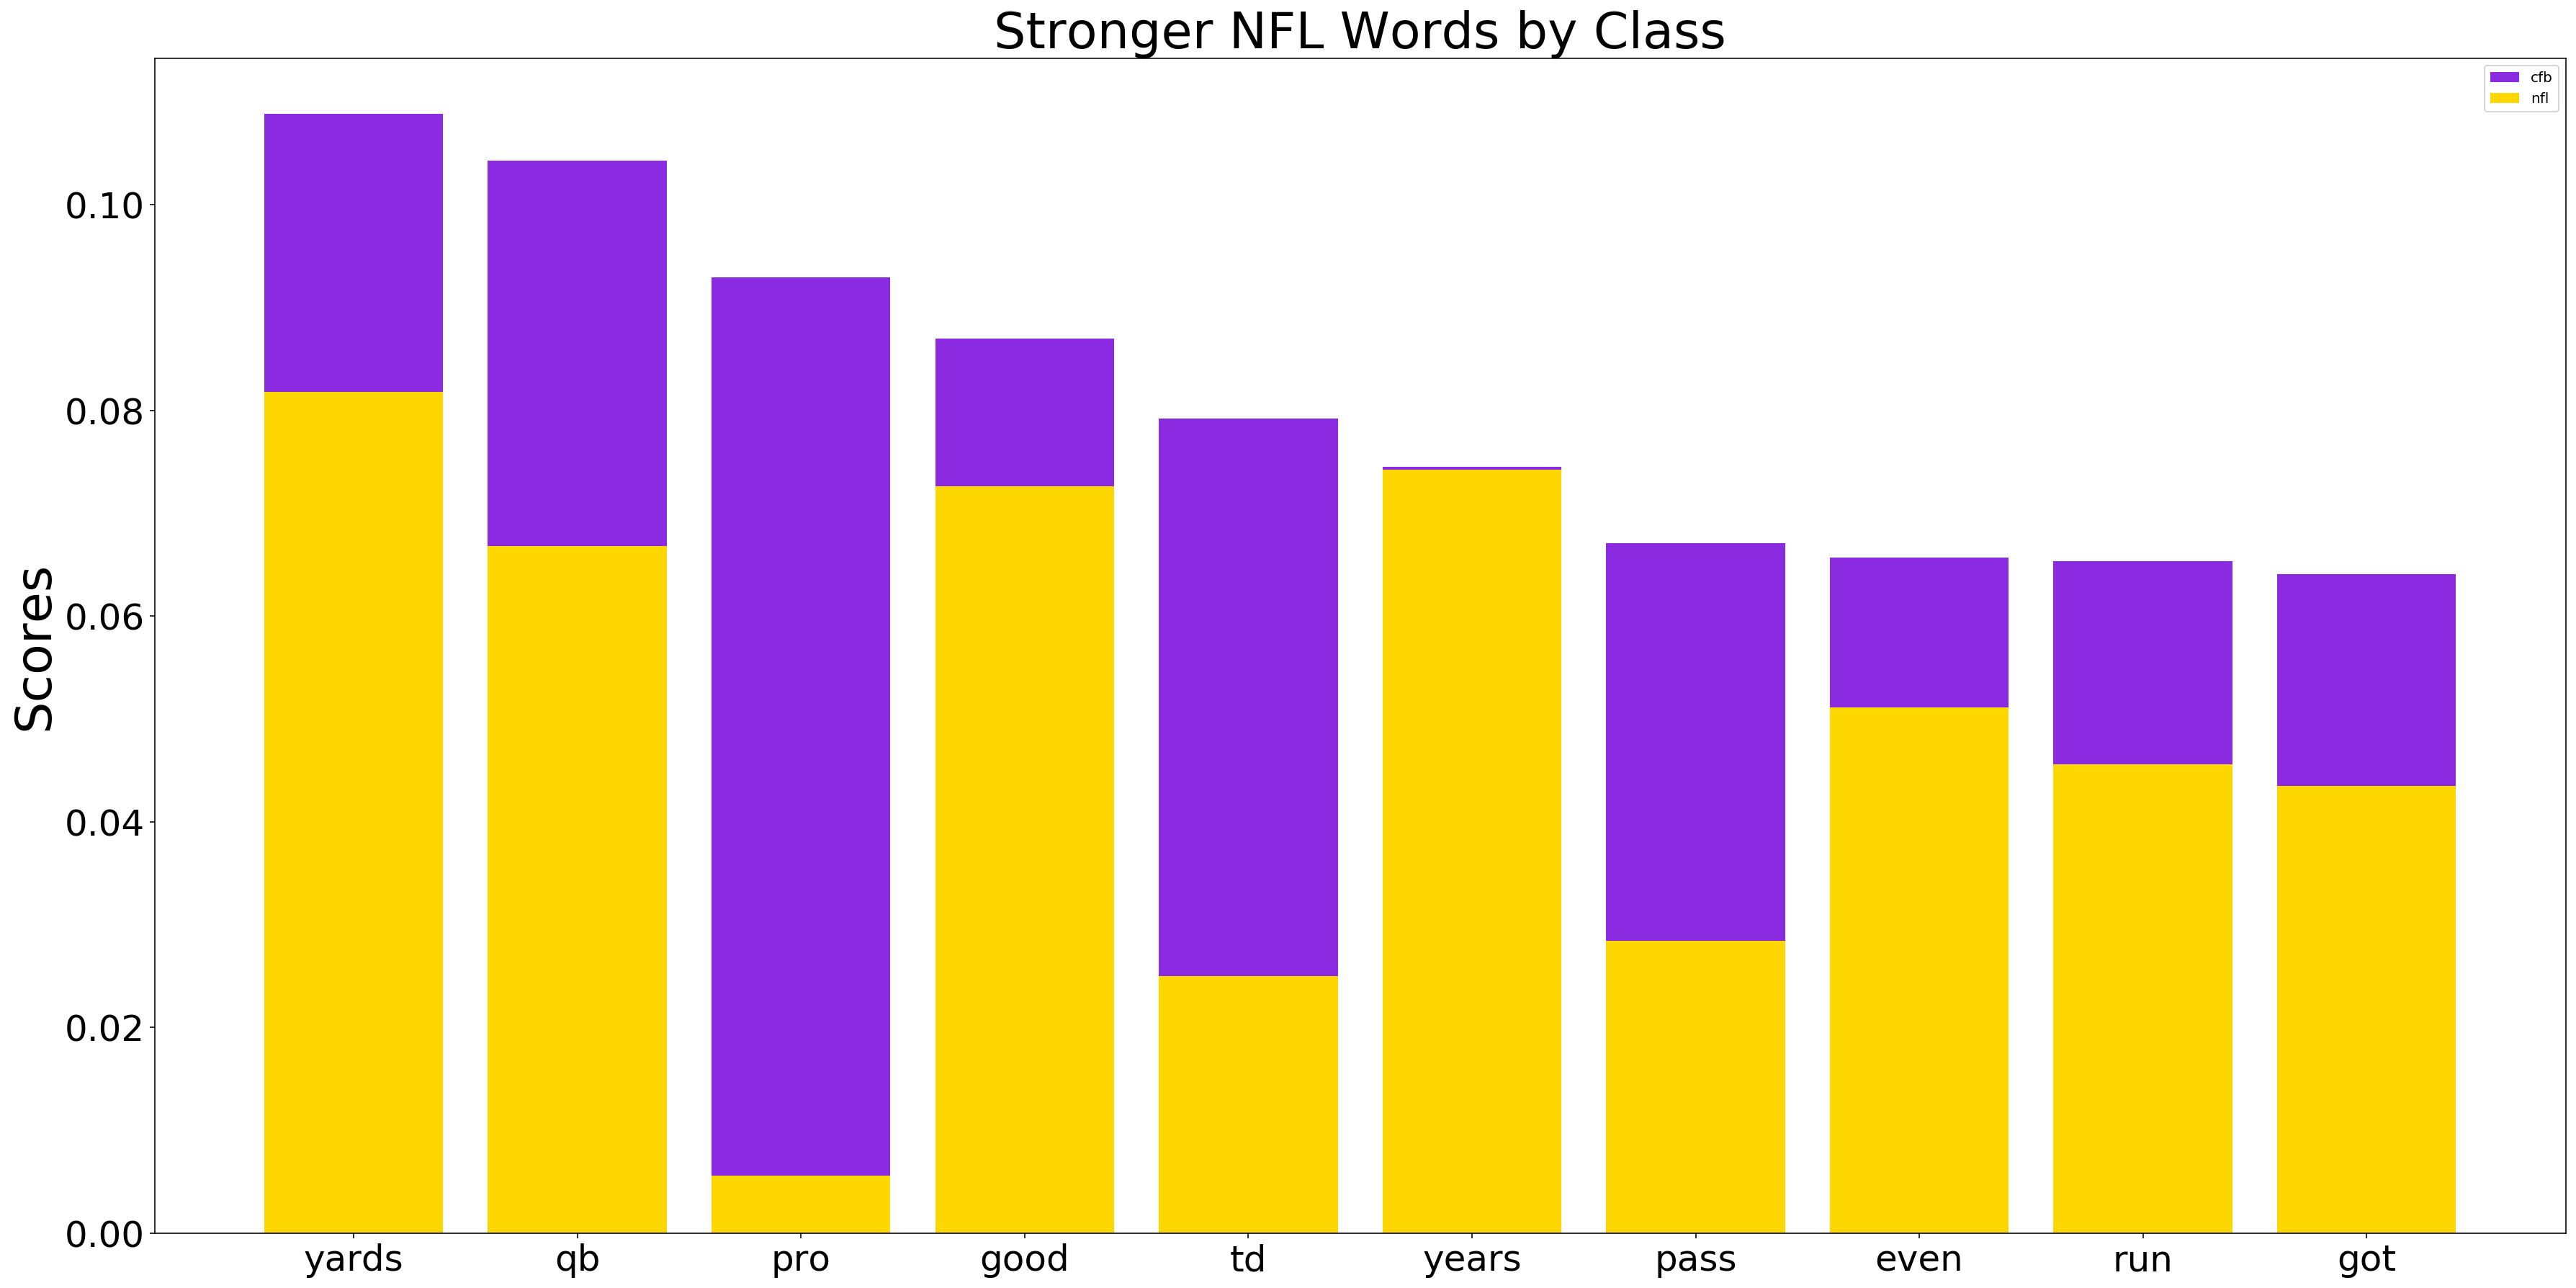

In [46]:
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(30)
rects1 = ax.bar(nfl_words_df.T.index[:10], nfl_words_df.T[0].head(10),color='blueviolet')
rects2 = ax.bar(nfl_words_df.T.index[:10], nfl_words_df.T[1].head(10), color='gold')

ax.set_ylabel('Scores', fontsize = 35)
ax.set_title('Stronger NFL Words by Class', fontsize = 35)
ax.tick_params(labelsize=25)

ax.legend((rects1[0], rects2[0]), ('cfb', 'nfl'))

storing top words from each subreddit into lists

In [47]:
top_words_cfb = list(term_df.groupby('sr_target').
     mean().T.sort_values(0, ascending=False).head(20).index)

top_words_nfl = list(term_df.groupby('sr_target').
     mean().T.sort_values(1, ascending=False).head(20).index)

creating list of overlapping top words from nfl and cfb subreddits

In [48]:
top_words_overlap = [cfb for cfb in top_words_cfb if cfb in top_words_nfl]

In [49]:
overlap_plot = term_df.groupby('sr_target')[top_words_overlap].mean()

plotting overlapping top words

In [50]:
overlap_plot[overlap_plot.index==0].values

array([[0.4997, 0.4715, 0.3319, 0.3302, 0.2946, 0.245 , 0.2358, 0.1772,
        0.1308]])

In [51]:
overlap_plot[overlap_plot.index==1].values

array([[0.1052, 0.2846, 0.2523, 0.1752, 0.0683, 0.131 , 0.0712, 0.0839,
        0.0879]])

In [52]:
overlap_plot.columns

Index(['player', 'game', 'team', 'season', 'football', 'teams', 'vs', 'games',
       'play'],
      dtype='object')

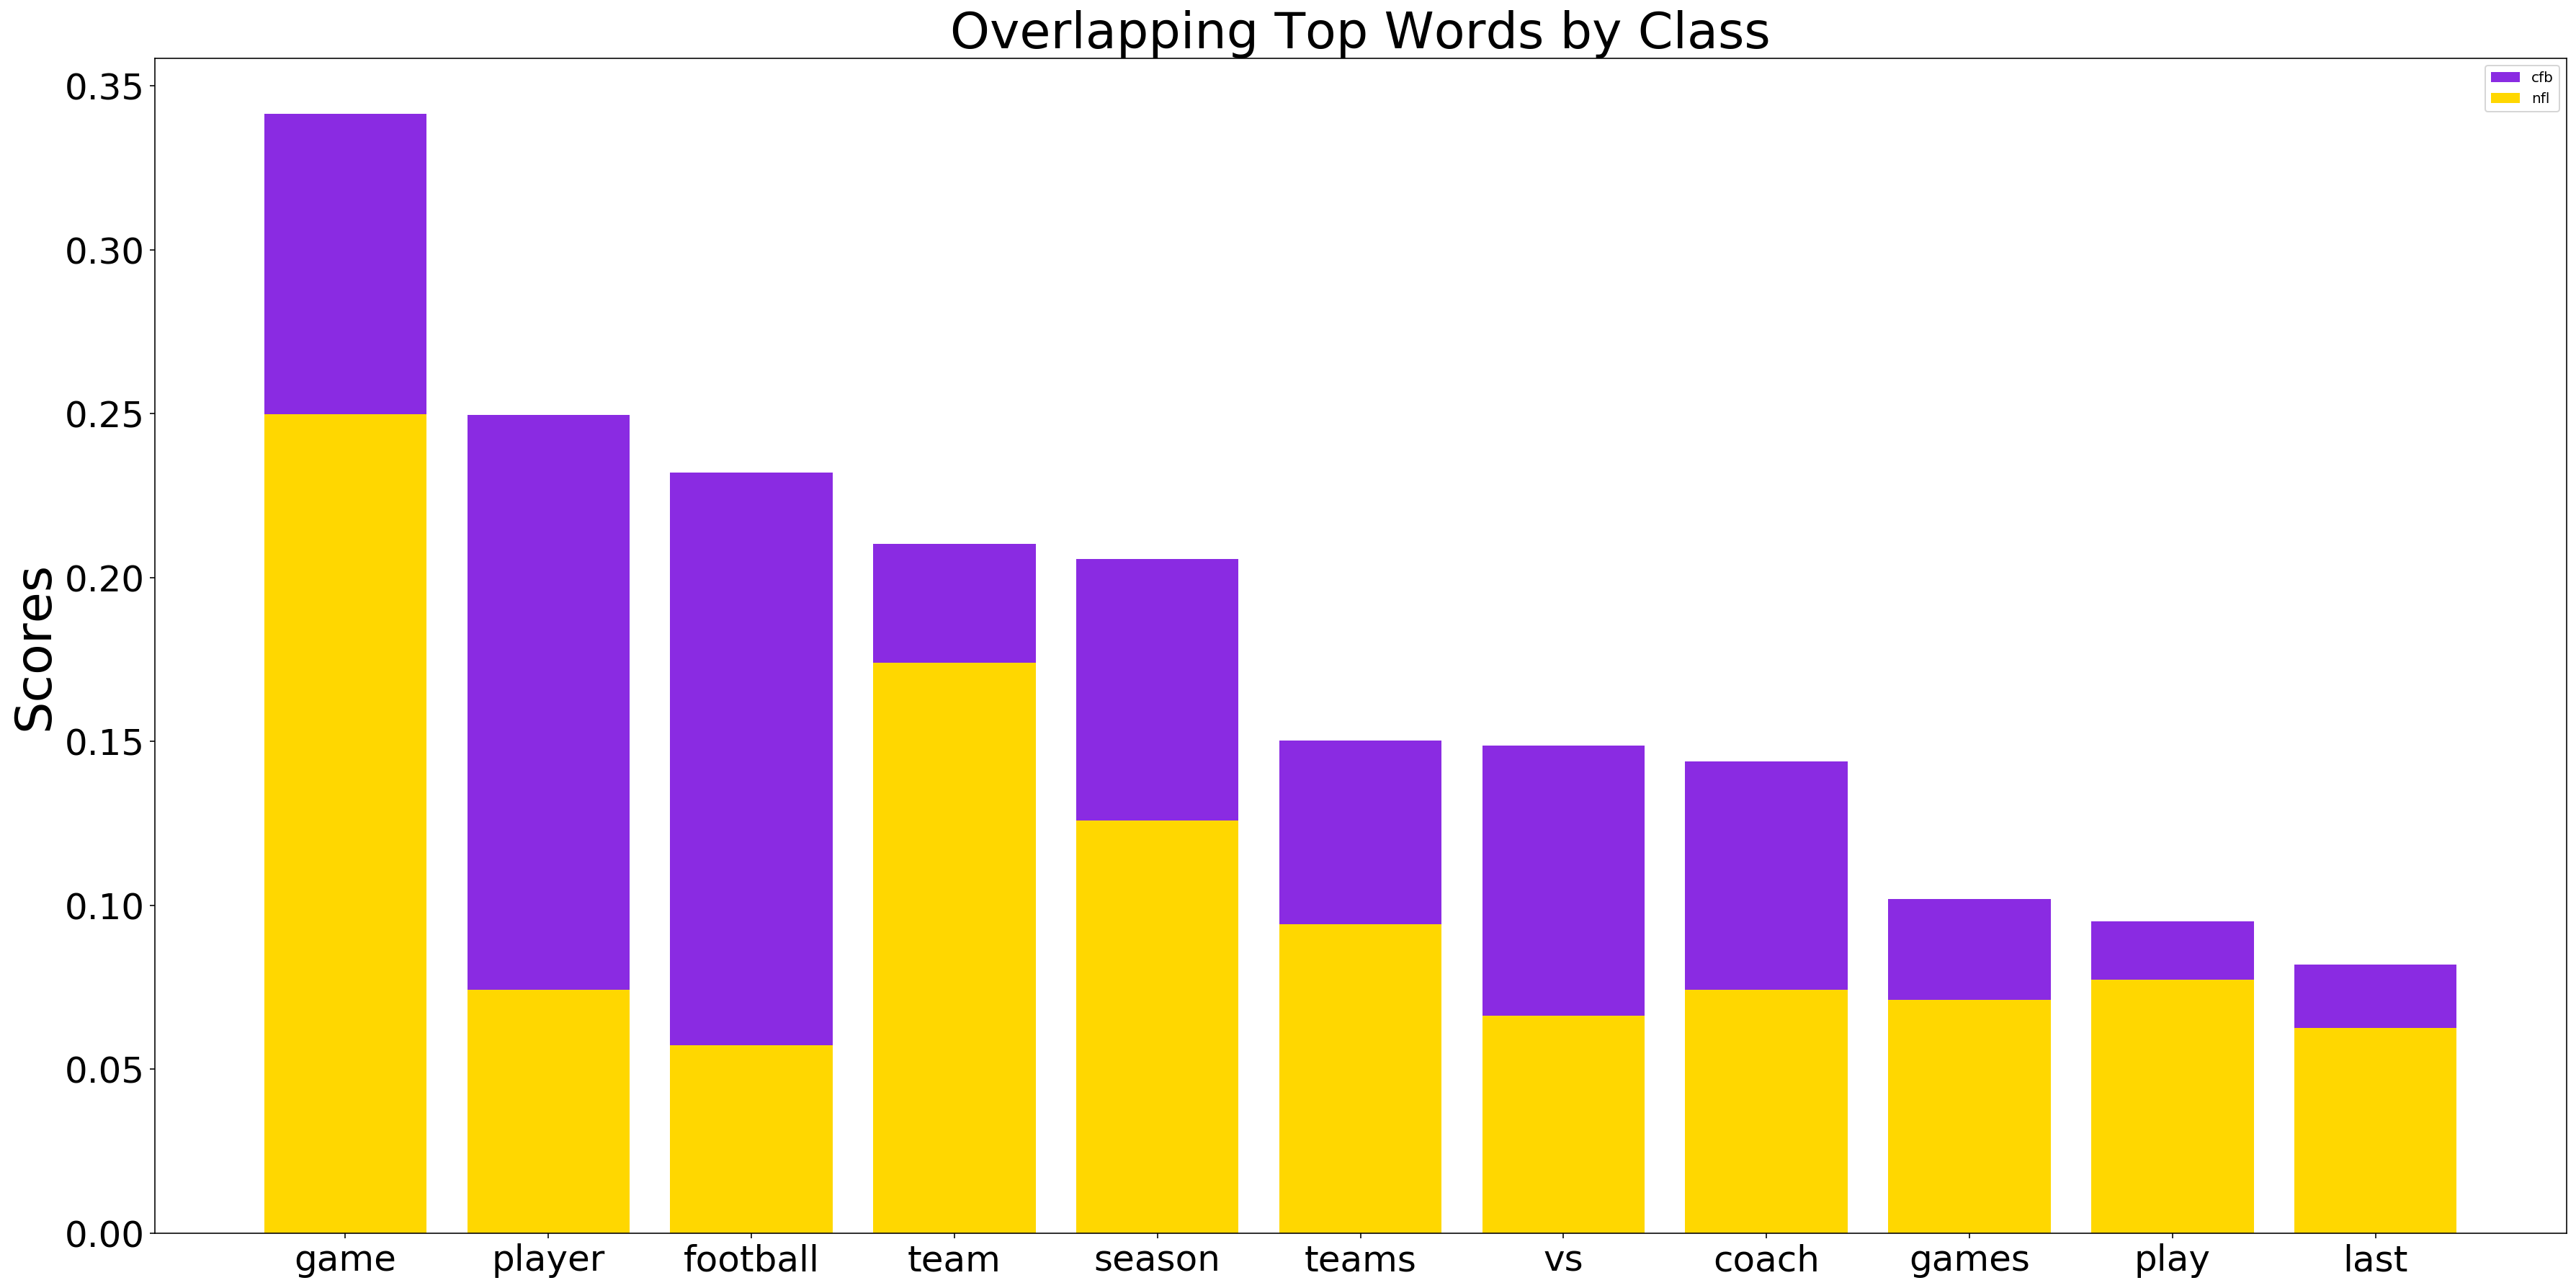

In [53]:
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(30)
rects1 = ax.bar(['game', 'player', 'football', 'team', 'season', 'teams', 'vs', 'coach',
       'games', 'play', 'last'], [0.3414, 0.2497, 0.2321, 0.2102, 0.2056, 0.1503, 0.1488, 0.1438,
        0.1018, 0.0951, 0.0818],color='blueviolet')

rects2 = ax.bar(['game', 'player', 'football', 'team', 'season', 'teams', 'vs', 'coach',
       'games', 'play', 'last'], [0.2498, 0.0743, 0.0573, 0.1739, 0.1259, 0.0943, 0.0663, 0.0743,
        0.0711, 0.0773, 0.0626], color='gold')

ax.set_ylabel('Scores', fontsize = 35)
ax.set_title('Overlapping Top Words by Class', fontsize = 35)
ax.tick_params(labelsize=25)

ax.legend((rects1[0], rects2[0]), ('cfb', 'nfl'))

running ttest for overlapping top words and term_df. using resulting p-value to remove features that are not significant

In [54]:
df_columns = term_df.drop('sr_target',axis=1).columns

In [55]:
term_df.to_csv('term_df.csv')

In [56]:
ttest_dict = {}
for word in top_words_overlap:
    ttest_dict[word] = ttest_ind(term_df[term_df['sr_target']==1][word], 
         term_df[term_df['sr_target']==0][word])

In [57]:
ttest_dict2 = {}
for word in df_columns:
    ttest_dict2[word] = ttest_ind(term_df[term_df['sr_target']==1][word], 
         term_df[term_df['sr_target']==0][word])

In [58]:
for key in ttest_dict:
    if ttest_dict[key][1] > .05:
        print(f"'{key}',")

In [59]:
for key in ttest_dict2:
    if ttest_dict2[key][1] > .05:
        print(f"'{key}',")

'080',
'090',
'119',
'160',
'162',
'167',
'184',
'186',
'188',
'1940',
'195',
'1951',
'1983',
'1990',
'1999',
'1x',
'2002',
'2014',
'2021',
'220',
'259',
'265',
'271',
'277',
'280',
'281',
'291',
'295',
'296',
'298',
'2nd',
'2x',
'300',
'302',
'317',
'318',
'319',
'321',
'334',
'342',
'344',
'366',
'367',
'36th',
'381',
'397',
'398',
'3x',
'409',
'414',
'416',
'421',
'423',
'424',
'434',
'444',
'453',
'465',
'466',
'472',
'476',
'485',
'490',
'4th',
'4x',
'500',
'5000',
'505',
'507',
'50th',
'512',
'513',
'519',
'523',
'547',
'548',
'5671',
'5b',
'5d',
'5x',
'616',
'621',
'649',
'666',
'673',
'696',
'6x',
'713',
'719',
'730',
'745',
'7th',
'7x',
'833',
'875',
'90s',
'_the',
'aaf',
'abuse',
'accomplishments',
'achieving',
'act',
'acting',
'active',
'actually',
'adam',
'adams',
'adds',
'advantage',
'affiliation',
'afl',
'agreement',
'agrees',
'akers',
'al',
'alas',
'albeit',
'alexander',
'alford',
'alike',
'alive',
'allegedly',
'allowed',
'allows',
'alphabetically',
'alternate',
'alterna

In [60]:
for key in ttest_dict:
    if ttest_dict[key][1] > .05:
        custom_stopwords.append(key)

In [61]:
for key in ttest_dict2:
    if ttest_dict2[key][1] > .05:
        custom_stopwords.append(key)